In [1]:
import os
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

In [2]:
def read_file(filename, columns=None, **kwargs):
    print(filename)
    load_extension = os.path.splitext(filename)[-1]
    if load_extension == ".parquet":
        return pd.read_parquet(filename, columns=columns,**kwargs)
    elif load_extension == ".csv":
        return pd.read_csv(filename, usecols=columns, **kwargs)

In [3]:
fpath = '/local-scratch/nigam/projects/lguo/temp_ds_shift_robustness/cohorts/admissions/cohort/'
df = read_file(f"{fpath}/cohort_split.parquet",engine='pyarrow')
df['admission_year']=df['admit_date'].dt.year
df = df.query("admission_year>2008")

/local-scratch/nigam/projects/lguo/temp_ds_shift_robustness/cohorts/admissions/cohort//cohort_split.parquet


In [4]:
# Confirm that each person_id is unique
print(
    df.shape[0],
    df['person_id'].nunique(),
)

211230 211230


In [5]:
df['gender_female'] = np.where(df['gender_concept_name']=='FEMALE',1,0)
df['gender_male'] = np.where(df['gender_concept_name']=='MALE',1,0)
df['race_white'] = np.where(df['race_eth']=='White',1,0)
df['race_other'] = np.where(df['race_eth']=='White',0,1)

In [6]:
for var in ['admission_year']:
    df_agg = df.groupby(var).agg(
        subject_count = ('person_id', 'count'),
        age_mean = ('age_in_years','mean'),
        age_std = ('age_in_years','std'),
        gender_F = ('gender_female','sum'),
        gender_M = ('gender_male','sum'),
        race_W = ('race_white','sum'),
        race_O = ('race_other','sum'),
        mortality = ('hospital_mortality','sum'),
        los_7 = ('LOS_7','sum'),
        readmission_30 = ('readmission_30','sum'),
        icu = ('icu_admission','sum'),
        subject_count_readmission = ('readmission_30','count'),
    ).reset_index().round(2)

    df_agg['gender_F_perc'] = df_agg['gender_F']/df_agg['subject_count']*100
    df_agg['gender_M_perc'] = df_agg['gender_M']/df_agg['subject_count']*100
    df_agg['race_W_perc'] = df_agg['race_W']/df_agg['subject_count']*100
    df_agg['race_O_perc'] = df_agg['race_O']/df_agg['subject_count']*100
    df_agg['mortality_perc'] = df_agg['mortality']/df_agg['subject_count']*100
    df_agg['los_7_perc'] = df_agg['los_7']/df_agg['subject_count']*100
    df_agg['readmission_30_perc'] = df_agg['readmission_30']/df_agg['subject_count_readmission']*100
    df_agg['icu_perc'] = df_agg['icu']/df_agg['subject_count']*100

    df_agg['Age'] = df_agg['age_mean'].apply('{:.0f}'.format)+'±'+df_agg['age_std'].apply('{:.0f}'.format)+''

    df_agg['Gender (Female)'] = df_agg['gender_F'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['gender_F_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['Gender (Male)'] = df_agg['gender_M'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['gender_M_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['Race (White)'] = df_agg['race_W'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['race_W_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['Race (Other)'] = df_agg['race_O'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['race_O_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['In-Hospital Mortality'] = df_agg['mortality'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['mortality_perc'].apply('{:.0f}'.format)+'%)'
    
    df_agg['LOS >7 Days'] = df_agg['los_7'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['los_7_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['Readmission 30 Days'] = df_agg['readmission_30'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['readmission_30_perc'].apply('{:.0f}'.format)+'%)'
    
    df_agg['ICU Admission'] = df_agg['icu'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['icu_perc'].apply('{:.0f}'.format)+'%)'

    df_agg = df_agg[['subject_count',var,'Age','Gender (Female)','Gender (Male)','Race (White)','Race (Other)','In-Hospital Mortality','LOS >7 Days','Readmission 30 Days','ICU Admission']]
    df_agg = df_agg.melt(id_vars=var)
    df_agg = df_agg.pivot(columns = var, values = 'value', index = 'variable')
    df_agg = df_agg.reindex(labels = [
        'subject_count',
        'Age',
        'Gender (Female)',
        'Gender (Male)',
        'Race (White)', 
        'Race (Other)',
        'In-Hospital Mortality',
        'LOS >7 Days',
        'Readmission 30 Days',
        'ICU Admission'
    ])
    display(df_agg)

admission_year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
variable,,,,,,,,,,,,,
subject_count,12727,12930,13104,13136,13117,15235,17241,16980,17198,21187,22514,22352,13509
Age,57±18,57±18,57±18,57±18,57±18,53±19,52±19,52±19,53±19,53±20,53±20,53±20,54±20
Gender (Female),6572 (52%),6579 (51%),6767 (52%),6576 (50%),6668 (51%),8820 (58%),10483 (61%),10310 (61%),10269 (60%),12874 (61%),13556 (60%),13234 (59%),8010 (59%)
Gender (Male),6154 (48%),6351 (49%),6337 (48%),6559 (50%),6448 (49%),6414 (42%),6757 (39%),6670 (39%),6929 (40%),8313 (39%),8956 (40%),9116 (41%),5496 (41%)
Race (White),7054 (55%),8106 (63%),8091 (62%),7848 (60%),7585 (58%),8092 (53%),8620 (50%),8174 (48%),8328 (48%),10164 (48%),10866 (48%),10101 (45%),5908 (44%)
Race (Other),5673 (45%),4824 (37%),5013 (38%),5288 (40%),5532 (42%),7143 (47%),8621 (50%),8806 (52%),8870 (52%),11023 (52%),11648 (52%),12251 (55%),7601 (56%)
In-Hospital Mortality,267 (2%),317 (2%),337 (3%),337 (3%),340 (3%),321 (2%),345 (2%),345 (2%),335 (2%),402 (2%),379 (2%),459 (2%),249 (2%)
LOS >7 Days,2680 (21%),2718 (21%),2720 (21%),2741 (21%),2703 (21%),2940 (19%),3065 (18%),3365 (20%),3264 (19%),3767 (18%),4078 (18%),4300 (19%),2709 (20%)
Readmission 30 Days,710 (6%),825 (7%),769 (6%),739 (6%),728 (6%),846 (6%),918 (5%),861 (5%),855 (5%),1225 (6%),1358 (6%),1261 (6%),713 (5%)


##### Proportion of admit_date and discharge_date that are at midnight

In [7]:
admit_diff = (df.admit_date - pd.to_datetime(df.admit_date.dt.date)) / np.timedelta64(1,'h')
discharge_diff = (df.discharge_date - pd.to_datetime(df.discharge_date.dt.date)) / np.timedelta64(1,'h')
print(
    f"admit_time at midnight [%]: {round(np.mean(admit_diff==0)*100,4)}\n"
    f"discharge_time at midnight [%]: {round(np.mean(admit_diff==0)*100,4)}"
)

admit_time at midnight [%]: 0.0473
discharge_time at midnight [%]: 0.0473


##### LOS distribution in hours

In [8]:
los = round((df.discharge_date - df.admit_date) / np.timedelta64(1,'m'))

(0.0, 10000.0)

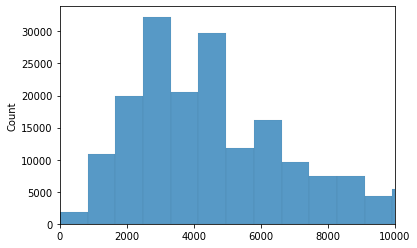

In [9]:
ax = sns.histplot(los,kde=False,bins=1000)
ax.set_xlim([0,10000])

In [10]:
min(los)

7.0

In [11]:
len(np.where(los<60)[0])

22

##### Prevalence by Year and Split

In [13]:
folds = df['fold_id'].unique().tolist()
years = df['admission_year'].unique().tolist()
tasks = ['hospital_mortality','LOS_7','readmission_30','icu_admission']
df_v = pd.DataFrame(columns=['year','fold','task','count','perc'])
c=0
for year in years:
    for fold in folds:
        for task in tasks:
            c+=1
            sample = df.query(f"{task}_fold_id==@fold and admission_year==@year")
            df_v.loc[c,:]=[year,fold,task,sample[task].sum(),sample[task].mean()]

In [15]:
df_v.pivot(index=['task','fold'],columns='year',values=['perc'])

perc                                          \
year                         2009      2010      2011      2012      2013   
task               fold                                                     
LOS_7              1     0.218294  0.198785  0.201635  0.199565  0.204137   
                   2      0.19248  0.206077  0.209264  0.201196  0.209581   
                   3     0.214927  0.214917  0.209809  0.212616   0.20098   
                   4     0.194164   0.20221  0.215376  0.216422   0.20098   
                   5     0.206625  0.225967  0.199564  0.215878  0.208606   
                   test  0.217391   0.20165  0.207125   0.21106  0.218607   
                   val   0.228392  0.221649  0.210071  0.204061  0.199187   
hospital_mortality 1     0.025814  0.022087  0.026158  0.026645  0.028307   
                   2      0.02413  0.021547  0.024523  0.021207  0.023952   
                   3     0.020763  0.019337  0.021253  0.029908  0.026688   
                   4     0.020763  0.027072   0.02181   0.02447   0.02451   
                   5     0.021898  0.028177  0.027808  0.027732  0.032135   
                   test   0.01362  0.027849  0.029517  0.023846  0.024911   
                   val    0.02043  0.025258  0.028484  0.025888  0.021341   
icu_admission      1     0.035354  0.077305  0.074114  0.072322  0.071856   
                   2      0.02862  0.074033   0.06921  0.063622  0.074034   
                   3     0.026936  0.073481   0.06376  0.079391  0.077342   
                   4     0.022447  0.067403  0.068157  0.070691  0.076797   
                   5     0.020213  0.066851  0.070883  0.069059  0.087691   
                   test   0.02462  0.067561  0.068193  0.073059  0.076767   
                   val   0.026716  0.070103   0.06765   0.06599  0.075203   
readmission_30     1     0.047235  0.062676  0.058758  0.059218  0.059944   
                   2     0.058079  0.075663  0.061453  0.057778  0.060792   
                   3     0.061891  0.054085  0.047327  0.061659  0.048685   
                   4     0.052149  0.061897  0.068004  0.065217   0.04746   
                   5     0.057979  0.067652  0.060011  0.059284  0.061902   
                   test  0.064259  0.076923  0.061877  0.056653  0.058916   
                   val   0.056684  0.058699  0.063874  0.045336  0.060748   

                                                                           \
year                         2014      2015      2016      2017      2018   
task               fold                                                     
LOS_7              1     0.195968  0.165286  0.214886  0.200581  0.162791   
                   2     0.202063    0.1715  0.206142  0.192691  0.187121   
                   3     0.189873  0.181442  0.190997  0.175664  0.176332   
                   4      0.18706  0.183099  0.202777  0.194767  0.175657   
                   5     0.202532  0.192292  0.193942  0.193602  0.184423   
                   test  0.182057  0.173627  0.191991  0.176037  0.181875   
                   val   0.192123  0.177494  0.187672  0.195736  0.176211   
hospital_mortality 1     0.021566  0.016984  0.023549  0.019103  0.017189   
                   2     0.025785  0.021127  0.022297  0.021179  0.019892   
                   3     0.021566   0.01657  0.019352  0.018688  0.022927   
                   4     0.024379  0.023612  0.014304   0.02201  0.019218   
                   5     0.021097  0.018235  0.021876  0.021188  0.020229   
                   test  0.017505  0.022815  0.020809     0.019  0.022026   
                   val   0.016193  0.020495  0.020024  0.015504  0.011643   
icu_admission      1     0.066573  0.060481   0.07275  0.056478  0.064375   
                   2     0.065166  0.058824  0.059739  0.076412  0.069791   
                   3     0.058134  0.057581  0.068995  0.057724  0.079568   
                   4     0.067042  0.057581  0.063946  0.053987   0.08058   
                   5    